# O projeto

A empresa de crédito quer revolucionar como as pessoas pegam empréstimo, tudo podendo ser feito pelo celular. Como o business da empresa é crédito, há grande preocupação com inadimplência.

Foi fornecido um banco de dados com os últimos empréstimos. A taxa de inadimplência é de 35%, com o uso de técnicas de machine learning é possível baixar para 25%?

O banco de dados é um um backup e possui o seguinte sistema relacional:


![](https://drive.google.com/uc?export=view&id=1_I5jjQNemsr2A45mo1ku2dMhz-pfGgzI)




.

# 0.0 Imports

In [ ]:
!pip install dataprep

In [ ]:
!pip install boruta

In [ ]:
pip install scikit-plot

In [5]:
from scikitplot import metrics  as mt

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.utils import np_utils
from keras.metrics import Precision
from keras.metrics import Recall
from tensorflow import keras

In [6]:
from google.colab import drive
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display         import Image
from IPython.core.display    import HTML
from sklearn import preprocessing
from dataprep.eda import create_report
from sklearn.preprocessing   import  MinMaxScaler
from boruta                  import BorutaPy
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, train_test_split

## 0.1 funções

In [7]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 importar dados

In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
dataframe = pd.read_csv("/content/drive/MyDrive/PROJETOS_DS/formacao_cd/dados.csv")

In [163]:
dataframe['Status']= dataframe['Status'].replace([0],3)
dataframe['Status']= dataframe['Status'].replace([1],0)
dataframe['Status']= dataframe['Status'].replace([3],1)

In [164]:
df,df_test = train_test_split(dataframe, train_size = 0.7, random_state = 42)

In [12]:
df.groupby(['Status']).size()

Status
0    490
1    210
dtype: int64

# 1.0 Descrição dos Dados

Uma olhada inicial nos dados para compreender os atributos com suas informações de centralidade, variação, formatação, etc.


'IDCREDITO': Identificador unico da tabela

'DURACAO': Em quantas parcelas vai pagar o emprestimo 

'HISTORICOCREDITO': Condições em emprestimos anteriores

'PROPOSITO': Em que será utilizado 

'VALOR': valor que retirou como emprestimo

'INVESTIMENTOS': Qual investimento possui

'EMPREGO':  Tempo de emprego ou Desempregado

'ESTADOCIVIL': Sexo + Estado Civil

'FIADORTERCEIRO': Tipo do fiador, se houver

'RESIDENCIADESDE': Tempo que esta morando na residência atual

'IDADE': Idade 

'TEMPOPARCELAMENTO':

'EMPRESTIMOEXISTENTE':

'OUTROSFINANCIAMENTOS': Possui outro financiamento 1=banco;2=loja;3=nenhum;

'HABITACAO': O borrower mora em 1=habitação propria;2=gratuita;3=alugada

'PROFISSAO': Qualificação profissional 

'DEPENDENTES': Quantos dependentes 

'SOCIOEMPRESA': é sócio de empresa? 1=Sim; 0=Nao;

'ESTRANGEIRO': 1=Sim; 0=Nao;

'STATUS': Mau pagador? 1=Sim; 0=Nao;


In [13]:
df1 = df.copy()

In [14]:
df1.head(10)

,IDCREDITO,Duracao,HISTORICO,PROPOSITO,Valor,INVESTIMENTOS,EMPREGO,TempoParcelamento,ESTADOCIVIL,FIADOR,ResidenciaDesde,Idade,OUTROSFINANCIAMENTOS,HABITACAO,EmprestimoExistente,PROFISSAO,Dependentes,SocioEmpresa,Estrangeiro,Status
541,557,18,sem creditos/todos pagos,veiculo novo,2278,100<=X<500,<1,3,feminino div/dep/cas,nao,3.0,28,nenhum,proria,2,qualificado,1,0,0,1
440,453,12,sem creditos/todos pagos,moveis,2759,<100\n,>=7,2,masculino solteiro,nao,4.0,34,nenhum,proria,2,qualificado,1,0,0,0
482,496,24,existentes/pagos,moveis,2996,Desconhecido\n,1<=X<4,2,masculino cas/viu,nao,4.0,20,nenhum,proria,1,qualificado,1,0,0,1
422,435,9,existentes/pagos,moveis,2136,<100\n,1<=X<4,3,masculino solteiro,nao,2.0,25,nenhum,proria,1,qualificado,1,0,0,0
778,798,12,Critico-outros creditos,moveis,1258,<100\n,<1,2,feminino div/dep/cas,nao,4.0,22,nenhum,alugada,2,nao qualificado,1,0,0,0
949,973,24,todos pagos,veiculo novo,1193,<100\n,Desempregado,1,feminino div/dep/cas,co requerente,4.0,29,nenhum,alugada,2,desempregado,1,0,0,1
334,344,18,existentes/pagos,abrir negocio,4439,<100\n,>=7,1,masculino solteiro,co requerente,1.0,33,banco,proria,1,altamente qualificado/empresario,1,1,0,0
576,593,21,existentes/pagos,abrir negocio,1572,>=1000,>=7,4,feminino div/dep/cas,nao,4.0,36,banco,proria,1,nao qualificado,1,0,0,0
934,957,30,Critico-outros creditos,reforma,3656,Desconhecido\n,>=7,4,masculino solteiro,nao,4.0,49,loja,proria,2,nao qualificado,1,0,0,0
567,584,36,existentes/pagos,reforma casa,2384,<100\n,<1,4,masculino solteiro,nao,1.0,33,nenhum,alugada,1,nao qualificado,1,0,0,1


In [15]:
df1.describe()

,IDCREDITO,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,EmprestimoExistente,Dependentes,SocioEmpresa,Estrangeiro,Status
count,700.000000,700.000000,700.000000,700.000000,694.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,501.242857,20.467143,3175.337143,2.987143,2.853026,35.691429,1.428571,1.158571,0.412857,0.035714,0.300000
std,288.205748,11.537353,2607.922830,1.109772,1.123672,11.403470,0.575400,0.365537,0.492700,0.185710,0.458585
min,1.000000,4.000000,276.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,242.750000,12.000000,1371.750000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,499.000000,18.000000,2262.000000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,752.250000,24.000000,3997.500000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,0.000000,1.000000
max,999.000000,72.000000,15945.000000,4.000000,4.000000,74.000000,4.000000,2.000000,1.000000,1.000000,1.000000


## 1.1 dimensões

In [16]:
print('Número de linhas: {}'. format(df1.shape[0]))
print('Número de colunas: {}'. format(df1.shape[1]))

Número de linhas: 700
Número de colunas: 20


## 1.2 Tipos de dados

In [17]:
df1.dtypes

IDCREDITO                 int64
Duracao                   int64
HISTORICO                object
PROPOSITO                object
Valor                     int64
INVESTIMENTOS            object
EMPREGO                  object
TempoParcelamento         int64
ESTADOCIVIL              object
FIADOR                   object
ResidenciaDesde         float64
Idade                     int64
OUTROSFINANCIAMENTOS     object
HABITACAO                object
EmprestimoExistente       int64
PROFISSAO                object
Dependentes               int64
SocioEmpresa              int64
Estrangeiro               int64
Status                    int64
dtype: object

## 1.3 NAs

In [18]:
df1.isna().sum()

IDCREDITO               0
Duracao                 0
HISTORICO               9
PROPOSITO               0
Valor                   0
INVESTIMENTOS           0
EMPREGO                 8
TempoParcelamento       0
ESTADOCIVIL             0
FIADOR                  0
ResidenciaDesde         6
Idade                   0
OUTROSFINANCIAMENTOS    0
HABITACAO               6
EmprestimoExistente     0
PROFISSAO               6
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
dtype: int64

# 2.0 Processamento e tratamento dos dados

In [19]:
df2 = df1.copy()

In [20]:
df2[df2.isna().any(axis=1)]

,IDCREDITO,Duracao,HISTORICO,PROPOSITO,Valor,INVESTIMENTOS,EMPREGO,TempoParcelamento,ESTADOCIVIL,FIADOR,ResidenciaDesde,Idade,OUTROSFINANCIAMENTOS,HABITACAO,EmprestimoExistente,PROFISSAO,Dependentes,SocioEmpresa,Estrangeiro,Status
990,745,39,Critico-outros creditos,moveis,14179,Desconhecido\n,4<=X<7,4,masculino solteiro,nao,4.0,30,nenhum,NaN,2,altamente qualificado/empresario,1,1,0,0
997,234,18,NaN,reforma,866,<100\n,1<=X<4,4,masculino cas/viu,sim,2.0,25,nenhum,proria,1,nao qualificado,1,0,0,0
682,676,30,NaN,reforma,4530,<100\n,4<=X<7,4,feminino div/dep/cas,nao,4.0,26,nenhum,alugada,1,altamente qualificado/empresario,1,1,0,0
61,35,12,existentes/pagos,moveis,1474,<100\n,<1,4,feminino div/dep/cas,nao,NaN,33,banco,proria,1,altamente qualificado/empresario,1,1,0,0
988,356,24,existentes/pagos,veiculo novo,1246,<100\n,<1,4,masculino solteiro,nao,2.0,23,loja,NaN,1,nao qualificado,1,0,0,1
956,945,15,existentes/pagos,moveis,1845,<100\n,<1,4,feminino div/dep/cas,sim,1.0,46,nenhum,NaN,1,qualificado,1,0,0,0
983,960,24,existentes/pagos,moveis,3069,100<=X<500,NaN,4,masculino solteiro,nao,NaN,30,nenhum,de graca,1,qualificado,1,0,0,0
999,565,24,NaN,abrir negocio,4712,Desconhecido\n,1<=X<4,4,masculino solteiro,nao,2.0,37,banco,proria,2,altamente qualificado/empresario,1,1,0,0
407,412,33,Critico-outros creditos,veiculo usado,7253,<100\n,4<=X<7,3,masculino solteiro,nao,2.0,35,nenhum,proria,2,NaN,1,1,0,0
979,200,18,Atrasos anteriores,moveis,4297,<100\n,>=7,4,maculino div/dep,nao,NaN,40,nenhum,proria,1,altamente qualificado/empresario,1,1,0,1


In [21]:
df2['HISTORICO'] = df2['HISTORICO'].fillna('sem_historico')

In [22]:
df2.groupby(['HISTORICO']).size()

HISTORICO
Atrasos anteriores           58
Critico-outros creditos     212
existentes/pagos            359
sem creditos/todos pagos     29
sem_historico                 9
todos pagos                  33
dtype: int64

Os NAN podem ser casos de pessoas que nunca trabalharam

In [23]:
df2['EMPREGO'] = df2['EMPREGO'].fillna('Desempregado')

In [24]:
df2.groupby(['EMPREGO']).size()

EMPREGO
1<=X<4          234
4<=X<7          114
<1              116
>=7             181
Desempregado     55
dtype: int64

Residencia   . ResidenciaDesde	Idade

In [25]:
df2['ResidenciaDesde'] = df2['ResidenciaDesde'].fillna(df2['ResidenciaDesde'].median())

In [26]:
df2.isna().sum()

IDCREDITO               0
Duracao                 0
HISTORICO               0
PROPOSITO               0
Valor                   0
INVESTIMENTOS           0
EMPREGO                 0
TempoParcelamento       0
ESTADOCIVIL             0
FIADOR                  0
ResidenciaDesde         0
Idade                   0
OUTROSFINANCIAMENTOS    0
HABITACAO               6
EmprestimoExistente     0
PROFISSAO               6
Dependentes             0
SocioEmpresa            0
Estrangeiro             0
Status                  0
dtype: int64

Habitação

In [27]:
df2['HABITACAO'] = df2['HABITACAO'].fillna('proria')

In [28]:
df2.groupby(['HABITACAO']).size()

HABITACAO
alugada     130
de graca     83
proria      487
dtype: int64

Profissão

In [29]:
df2['PROFISSAO'] = df2['PROFISSAO'].fillna('qualificado')

In [30]:
df2.groupby(['PROFISSAO']).size()

PROFISSAO
altamente qualificado/empresario     97
desempregado                         18
nao qualificado                     145
qualificado                         440
dtype: int64

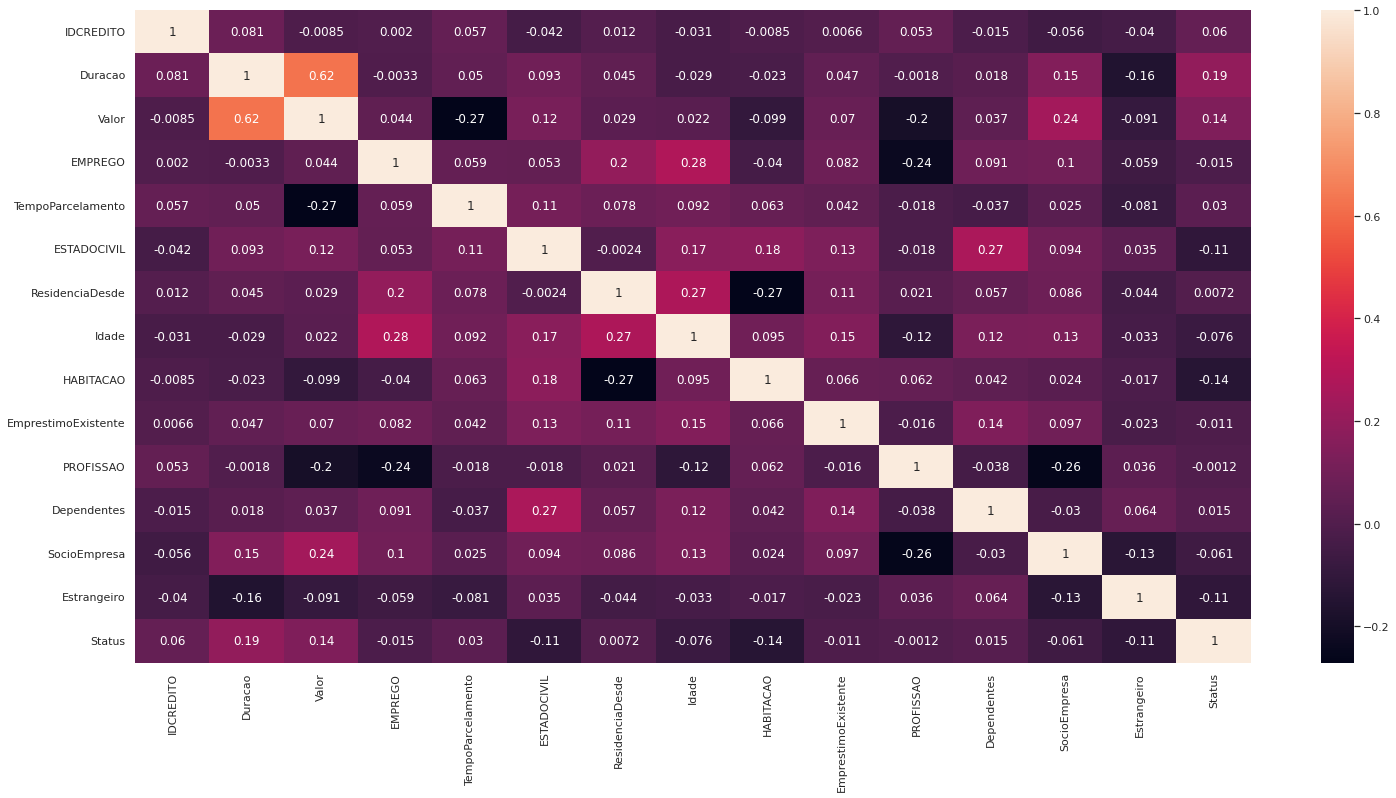

In [31]:
aux = df2.copy()

le = preprocessing.LabelEncoder()

aux['HABITACAO']=le.fit_transform(aux['HABITACAO'])

aux['EMPREGO']=le.fit_transform(aux['EMPREGO'])

aux['ESTADOCIVIL']=le.fit_transform(aux['ESTADOCIVIL'])

aux['PROFISSAO']=le.fit_transform(aux['PROFISSAO'])

correlation = aux.corr(method='pearson')
sns.heatmap(correlation, annot=True)

In [32]:
aux.head()

,IDCREDITO,Duracao,HISTORICO,PROPOSITO,Valor,INVESTIMENTOS,EMPREGO,TempoParcelamento,ESTADOCIVIL,FIADOR,ResidenciaDesde,Idade,OUTROSFINANCIAMENTOS,HABITACAO,EmprestimoExistente,PROFISSAO,Dependentes,SocioEmpresa,Estrangeiro,Status
541,557,18,sem creditos/todos pagos,veiculo novo,2278,100<=X<500,2,3,0,nao,3.0,28,nenhum,2,2,3,1,0,0,1
440,453,12,sem creditos/todos pagos,moveis,2759,<100\n,3,2,3,nao,4.0,34,nenhum,2,2,3,1,0,0,0
482,496,24,existentes/pagos,moveis,2996,Desconhecido\n,0,2,2,nao,4.0,20,nenhum,2,1,3,1,0,0,1
422,435,9,existentes/pagos,moveis,2136,<100\n,0,3,3,nao,2.0,25,nenhum,2,1,3,1,0,0,0
778,798,12,Critico-outros creditos,moveis,1258,<100\n,2,2,0,nao,4.0,22,nenhum,0,2,2,1,0,0,0


In [33]:
df2.describe()

,IDCREDITO,Duracao,Valor,TempoParcelamento,ResidenciaDesde,Idade,EmprestimoExistente,Dependentes,SocioEmpresa,Estrangeiro,Status
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,501.242857,20.467143,3175.337143,2.987143,2.854286,35.691429,1.428571,1.158571,0.412857,0.035714,0.300000
std,288.205748,11.537353,2607.922830,1.109772,1.118921,11.403470,0.575400,0.365537,0.492700,0.185710,0.458585
min,1.000000,4.000000,276.000000,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,242.750000,12.000000,1371.750000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,499.000000,18.000000,2262.000000,3.000000,3.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,752.250000,24.000000,3997.500000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000,0.000000,1.000000
max,999.000000,72.000000,15945.000000,4.000000,4.000000,74.000000,4.000000,2.000000,1.000000,1.000000,1.000000


In [34]:
df2[['ResidenciaDesde']] = df2[['ResidenciaDesde']].astype(object)
df2.dtypes

IDCREDITO                int64
Duracao                  int64
HISTORICO               object
PROPOSITO               object
Valor                    int64
INVESTIMENTOS           object
EMPREGO                 object
TempoParcelamento        int64
ESTADOCIVIL             object
FIADOR                  object
ResidenciaDesde         object
Idade                    int64
OUTROSFINANCIAMENTOS    object
HABITACAO               object
EmprestimoExistente      int64
PROFISSAO               object
Dependentes              int64
SocioEmpresa             int64
Estrangeiro              int64
Status                   int64
dtype: object

# 3.0 Análise exploratória dos dados

In [35]:
df3 = df2.copy()

In [36]:
df3.dtypes

IDCREDITO                int64
Duracao                  int64
HISTORICO               object
PROPOSITO               object
Valor                    int64
INVESTIMENTOS           object
EMPREGO                 object
TempoParcelamento        int64
ESTADOCIVIL             object
FIADOR                  object
ResidenciaDesde         object
Idade                    int64
OUTROSFINANCIAMENTOS    object
HABITACAO               object
EmprestimoExistente      int64
PROFISSAO               object
Dependentes              int64
SocioEmpresa             int64
Estrangeiro              int64
Status                   int64
dtype: object

In [37]:
le = preprocessing.LabelEncoder()

df3['HISTORICO']=le.fit_transform(df3['HISTORICO'])

df3['PROPOSITO']=le.fit_transform(df3['PROPOSITO'])

df3['INVESTIMENTOS']=le.fit_transform(df3['INVESTIMENTOS'])

df3['EMPREGO']=le.fit_transform(df3['EMPREGO'])

df3['ESTADOCIVIL']=le.fit_transform(df3['ESTADOCIVIL'])

df3['FIADOR']=le.fit_transform(df3['FIADOR'])

df3['ResidenciaDesde']=le.fit_transform(df3['ResidenciaDesde'])

df3['OUTROSFINANCIAMENTOS']=le.fit_transform(df3['OUTROSFINANCIAMENTOS'])

df3['HABITACAO']=le.fit_transform(df3['HABITACAO'])

df3['PROFISSAO']=le.fit_transform(df3['PROFISSAO'])

In [38]:
# boxplot

DataPrep Report
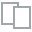
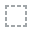
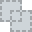
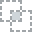
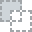
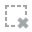
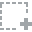
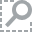
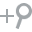
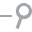
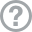
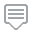
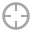
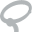
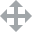
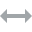
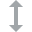
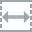
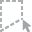
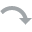
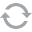
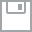
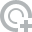
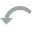
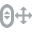
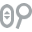
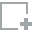
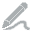
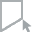
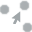
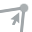
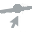

In [39]:
create_report(df3)

### 3.1 Variável resposta

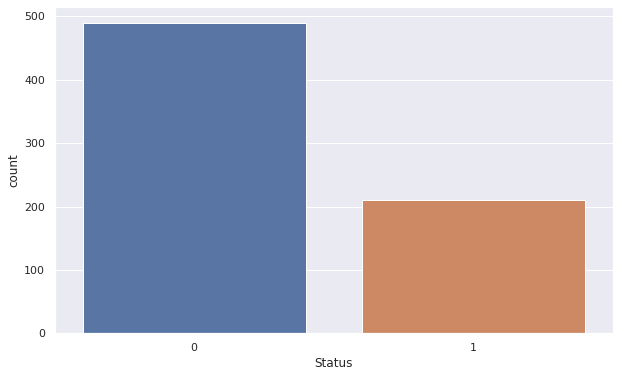

In [40]:
plt.figure(figsize=(10,6))
sns.countplot(x=df3['Status'])

In [41]:
df3.groupby(['Status']).size()

Status
0    490
1    210
dtype: int64

### 3.2 Variável numérica

maior parte dessas variáveis na vdd são categóricas. modificar e inserir dentro da análise de categóricas

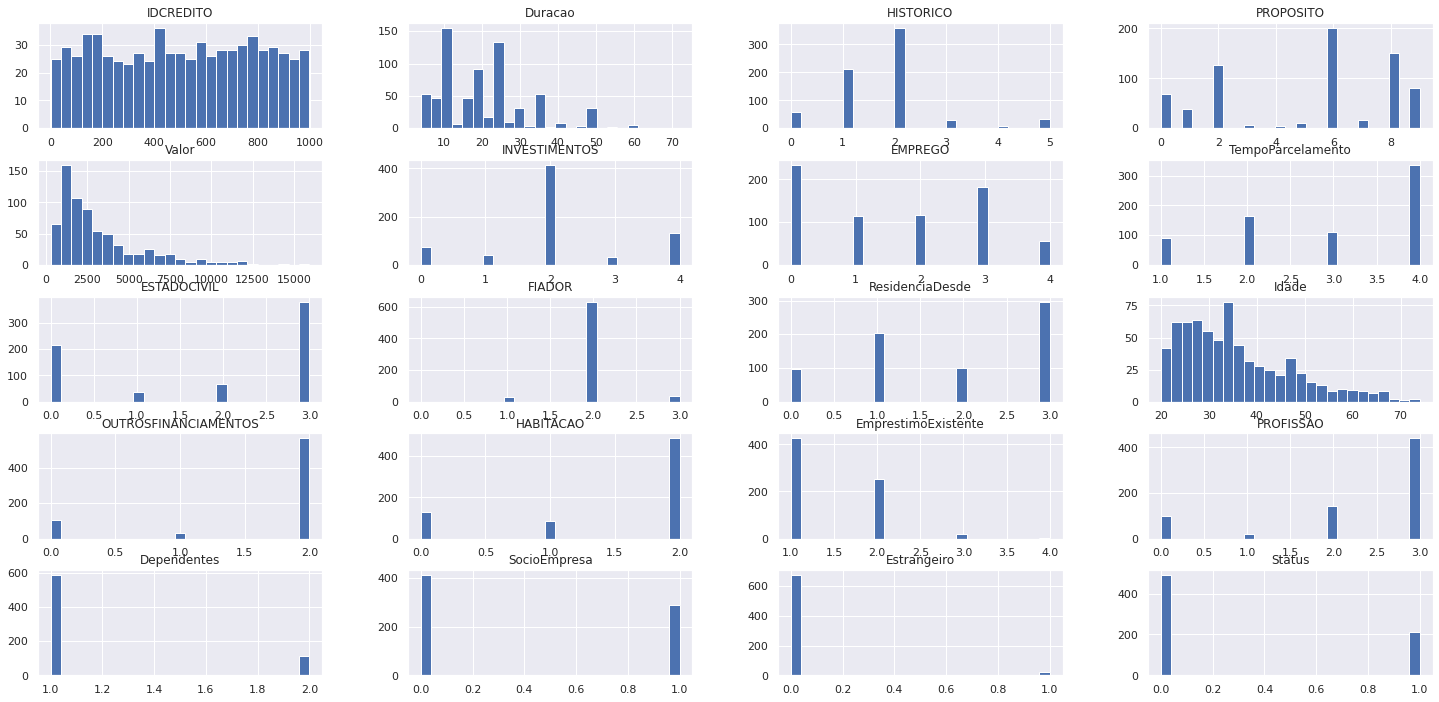

In [42]:
num_attributes = df3.select_dtypes(include = ['int64','float64'])
num_attributes.hist(bins = 25);

### 3.3 Variável categórica

(0.0, 300.0)

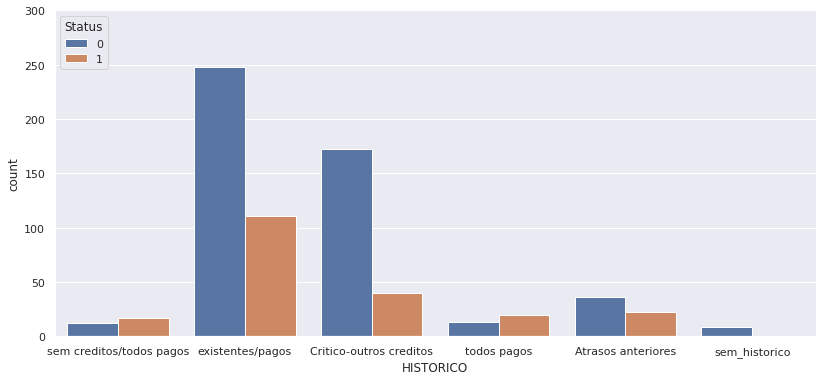

In [43]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='HISTORICO', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

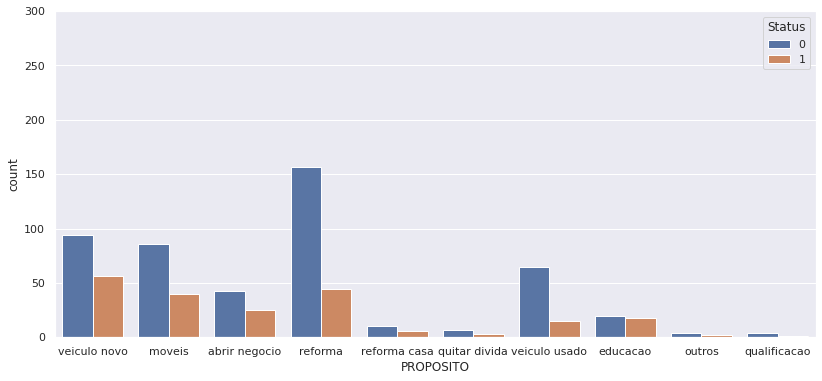

In [44]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='PROPOSITO', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

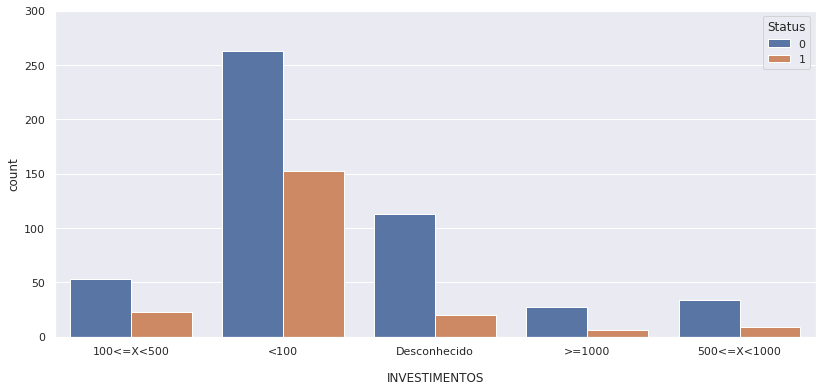

In [45]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='INVESTIMENTOS', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

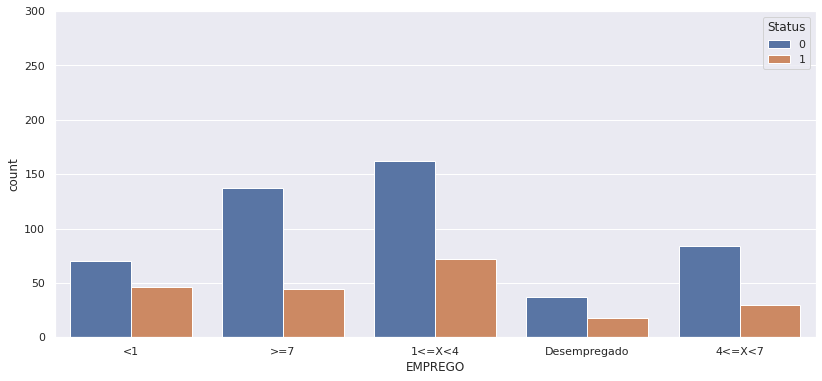

In [46]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='EMPREGO', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

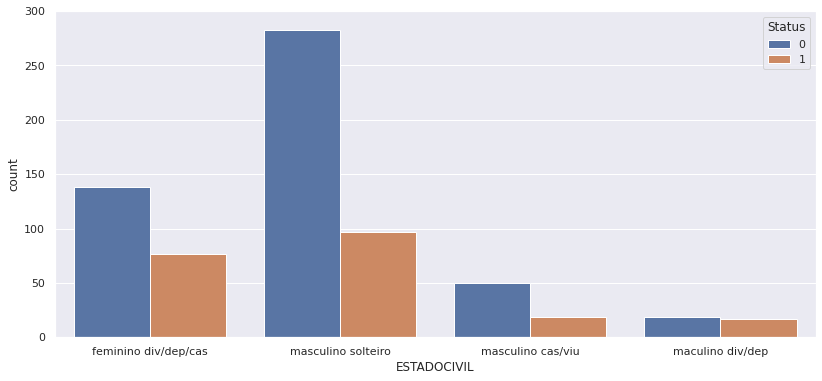

In [47]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='ESTADOCIVIL', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

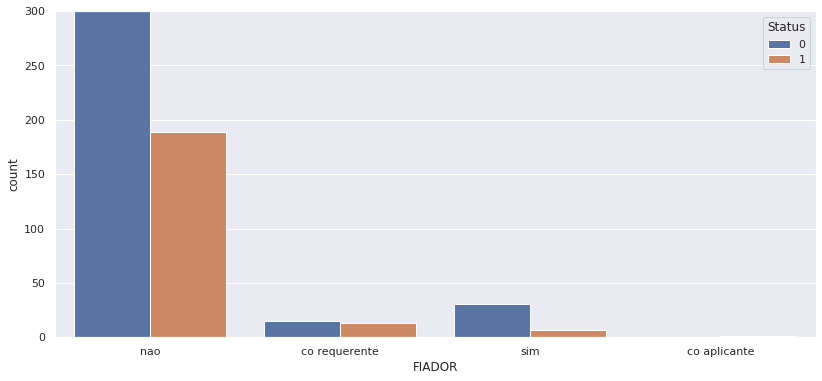

In [48]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='FIADOR', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

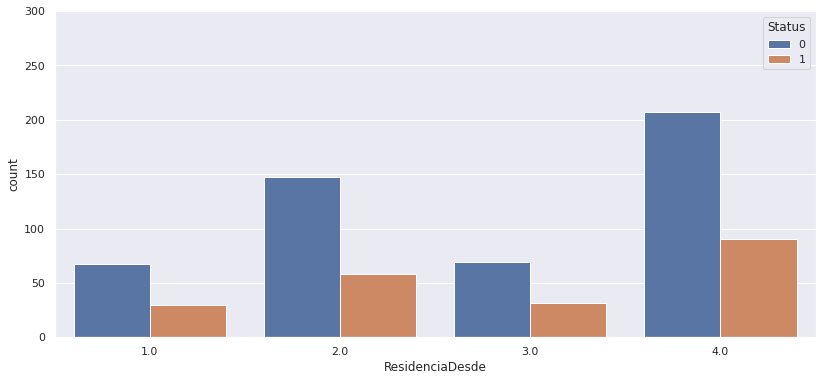

In [49]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='ResidenciaDesde', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

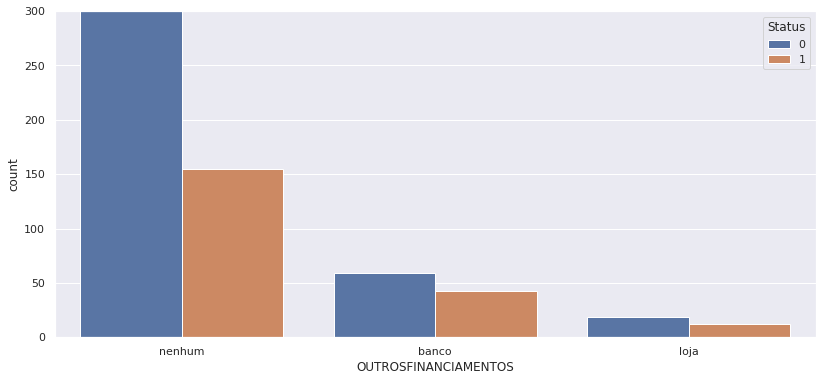

In [50]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='OUTROSFINANCIAMENTOS', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

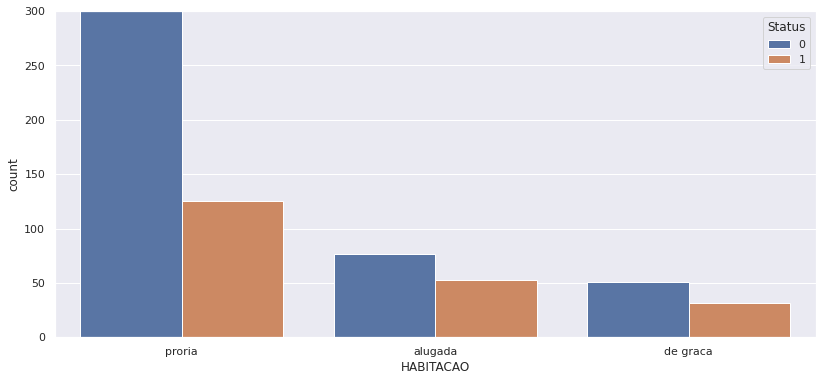

In [51]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='HABITACAO', data = df2, hue='Status')
ax.set_ylim([0,300])

(0.0, 300.0)

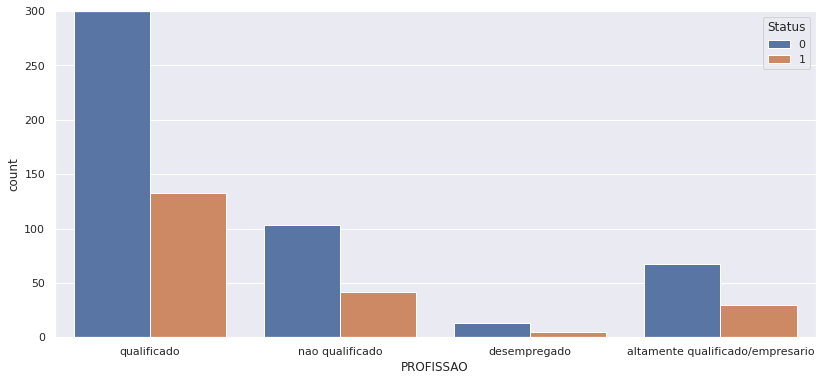

In [52]:
plt.figure(figsize=(30,6))

plt.subplot(1,2,1)
ax = sns.countplot(x='PROFISSAO', data = df2, hue='Status')
ax.set_ylim([0,300])

# 4.0 Preparação dos dados para a modelagem

In [53]:
df4 = df2.copy()

In [54]:
df4.dtypes

IDCREDITO                int64
Duracao                  int64
HISTORICO               object
PROPOSITO               object
Valor                    int64
INVESTIMENTOS           object
EMPREGO                 object
TempoParcelamento        int64
ESTADOCIVIL             object
FIADOR                  object
ResidenciaDesde         object
Idade                    int64
OUTROSFINANCIAMENTOS    object
HABITACAO               object
EmprestimoExistente      int64
PROFISSAO               object
Dependentes              int64
SocioEmpresa             int64
Estrangeiro              int64
Status                   int64
dtype: object

## 4.1 Transformação das variáveis

In [55]:
#  One Hot Encoding
#df4 = pd.get_dummies( df4, prefix=['PROPOSITO'], columns=['PROFISSAO'] )

In [56]:
df4.head(10)

,IDCREDITO,Duracao,HISTORICO,PROPOSITO,Valor,INVESTIMENTOS,EMPREGO,TempoParcelamento,ESTADOCIVIL,FIADOR,ResidenciaDesde,Idade,OUTROSFINANCIAMENTOS,HABITACAO,EmprestimoExistente,PROFISSAO,Dependentes,SocioEmpresa,Estrangeiro,Status
541,557,18,sem creditos/todos pagos,veiculo novo,2278,100<=X<500,<1,3,feminino div/dep/cas,nao,3.0,28,nenhum,proria,2,qualificado,1,0,0,1
440,453,12,sem creditos/todos pagos,moveis,2759,<100\n,>=7,2,masculino solteiro,nao,4.0,34,nenhum,proria,2,qualificado,1,0,0,0
482,496,24,existentes/pagos,moveis,2996,Desconhecido\n,1<=X<4,2,masculino cas/viu,nao,4.0,20,nenhum,proria,1,qualificado,1,0,0,1
422,435,9,existentes/pagos,moveis,2136,<100\n,1<=X<4,3,masculino solteiro,nao,2.0,25,nenhum,proria,1,qualificado,1,0,0,0
778,798,12,Critico-outros creditos,moveis,1258,<100\n,<1,2,feminino div/dep/cas,nao,4.0,22,nenhum,alugada,2,nao qualificado,1,0,0,0
949,973,24,todos pagos,veiculo novo,1193,<100\n,Desempregado,1,feminino div/dep/cas,co requerente,4.0,29,nenhum,alugada,2,desempregado,1,0,0,1
334,344,18,existentes/pagos,abrir negocio,4439,<100\n,>=7,1,masculino solteiro,co requerente,1.0,33,banco,proria,1,altamente qualificado/empresario,1,1,0,0
576,593,21,existentes/pagos,abrir negocio,1572,>=1000,>=7,4,feminino div/dep/cas,nao,4.0,36,banco,proria,1,nao qualificado,1,0,0,0
934,957,30,Critico-outros creditos,reforma,3656,Desconhecido\n,>=7,4,masculino solteiro,nao,4.0,49,loja,proria,2,nao qualificado,1,0,0,0
567,584,36,existentes/pagos,reforma casa,2384,<100\n,<1,4,masculino solteiro,nao,1.0,33,nenhum,alugada,1,nao qualificado,1,0,0,1


In [57]:
# HISTORICO
historico_dict = {'todos pagos': 1,  'sem creditos/todos pagos': 2, 
                  'Atrasos anteriores': 3,  'existentes/pagos': 4, 
                  'Critico-outros creditos': 5, 'sem_historico': 6}
df4['HISTORICO'] = df4['HISTORICO'].map( historico_dict )

# PROPOSITO
le_proposito = preprocessing.LabelEncoder()
le_proposito.fit(df4['PROPOSITO'])
df4['PROPOSITO']=le_proposito.transform(df4['PROPOSITO'])
pickle.dump( le_proposito, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/PROPOSITO_scaler.pkl', 'wb') ) ###############

# INVESTIMENTOS
le_INVESTIMENTOS = preprocessing.LabelEncoder()
le_INVESTIMENTOS.fit(df4['INVESTIMENTOS'])
df4['INVESTIMENTOS']=le_INVESTIMENTOS.transform(df4['INVESTIMENTOS'])
pickle.dump( le_INVESTIMENTOS, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/INVESTIMENTOS_scaler.pkl', 'wb') ) ###############

# EMPREGO

le_EMPREGO = preprocessing.LabelEncoder()
le_EMPREGO.fit(df4['EMPREGO'])
df4['EMPREGO']=le_EMPREGO.transform(df4['EMPREGO'])
pickle.dump( le_EMPREGO, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/EMPREGO_scaler.pkl', 'wb') ) ###############

# ESTADOCIVIL
le_ESTADOCIVIL = preprocessing.LabelEncoder()
le_ESTADOCIVIL.fit(df4['ESTADOCIVIL'])
df4['ESTADOCIVIL']=le_ESTADOCIVIL.transform(df4['ESTADOCIVIL'])
pickle.dump( le_ESTADOCIVIL, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/ESTADOCIVIL_scaler.pkl', 'wb') ) ###############

# FIADOR
FIADOR_dict = {'co aplicante': 1,  'co requerente': 2, 
                  'nao': 3,  'sim': 4}
df4['FIADOR'] = df4['FIADOR'].map( FIADOR_dict )

# ResidenciaDesde
le_ResidenciaDesde = preprocessing.LabelEncoder()
le_ResidenciaDesde.fit(df4['ResidenciaDesde'])
df4['ResidenciaDesde']=le_ResidenciaDesde.transform(df4['ResidenciaDesde'])
pickle.dump( le_ResidenciaDesde, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/ResidenciaDesde_scaler.pkl', 'wb') ) ###############

# OUTROSFINANCIAMENTOS
le_OUTROSFINANCIAMENTOS = preprocessing.LabelEncoder()
le_OUTROSFINANCIAMENTOS.fit(df4['OUTROSFINANCIAMENTOS'])
df4['OUTROSFINANCIAMENTOS']=le_OUTROSFINANCIAMENTOS.transform(df4['OUTROSFINANCIAMENTOS'])
pickle.dump( le_OUTROSFINANCIAMENTOS, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/OUTROSFINANCIAMENTOS_scaler.pkl', 'wb') ) ###############

# HABITACAO
le_HABITACAO = preprocessing.LabelEncoder()
le_HABITACAO.fit(df4['HABITACAO'])
df4['HABITACAO']=le_HABITACAO.transform(df4['HABITACAO'])
pickle.dump( le_HABITACAO, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/HABITACAO_scaler.pkl', 'wb') ) ###############

# PROFISSAO
le_PROFISSAO = preprocessing.LabelEncoder()
le_PROFISSAO.fit(df4['PROFISSAO'])
df4['PROFISSAO']=le_PROFISSAO.transform(df4['PROFISSAO'])
pickle.dump( le_PROFISSAO, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/PROFISSAO_scaler.pkl', 'wb') ) ###############

## 4.2 Padronização dos dados

In [58]:
#variables = df4.columns.tolist()

#f, axes = plt.subplots(2, 10, figsize = (20, 20))
#for var, ax in zip(variables, f.axes):
#   b = sns.boxplot(y = var, data = df4, ax = ax)
#    b.axes.set_title(var,fontsize = 15)
#    b.set_ylabel("")
#plt.tight_layout()
#plt.show()

In [59]:
scaler = MinMaxScaler()
scaler.fit(df4)
df4_ = scaler.transform(df4)
pickle.dump( scaler, open( '/content/drive/MyDrive/PROJETOS_DS/formacao_cd/parameter/scaler_scaler.pkl', 'wb') ) ###############

df4_d = pd.DataFrame(df4_, columns = df4.columns)

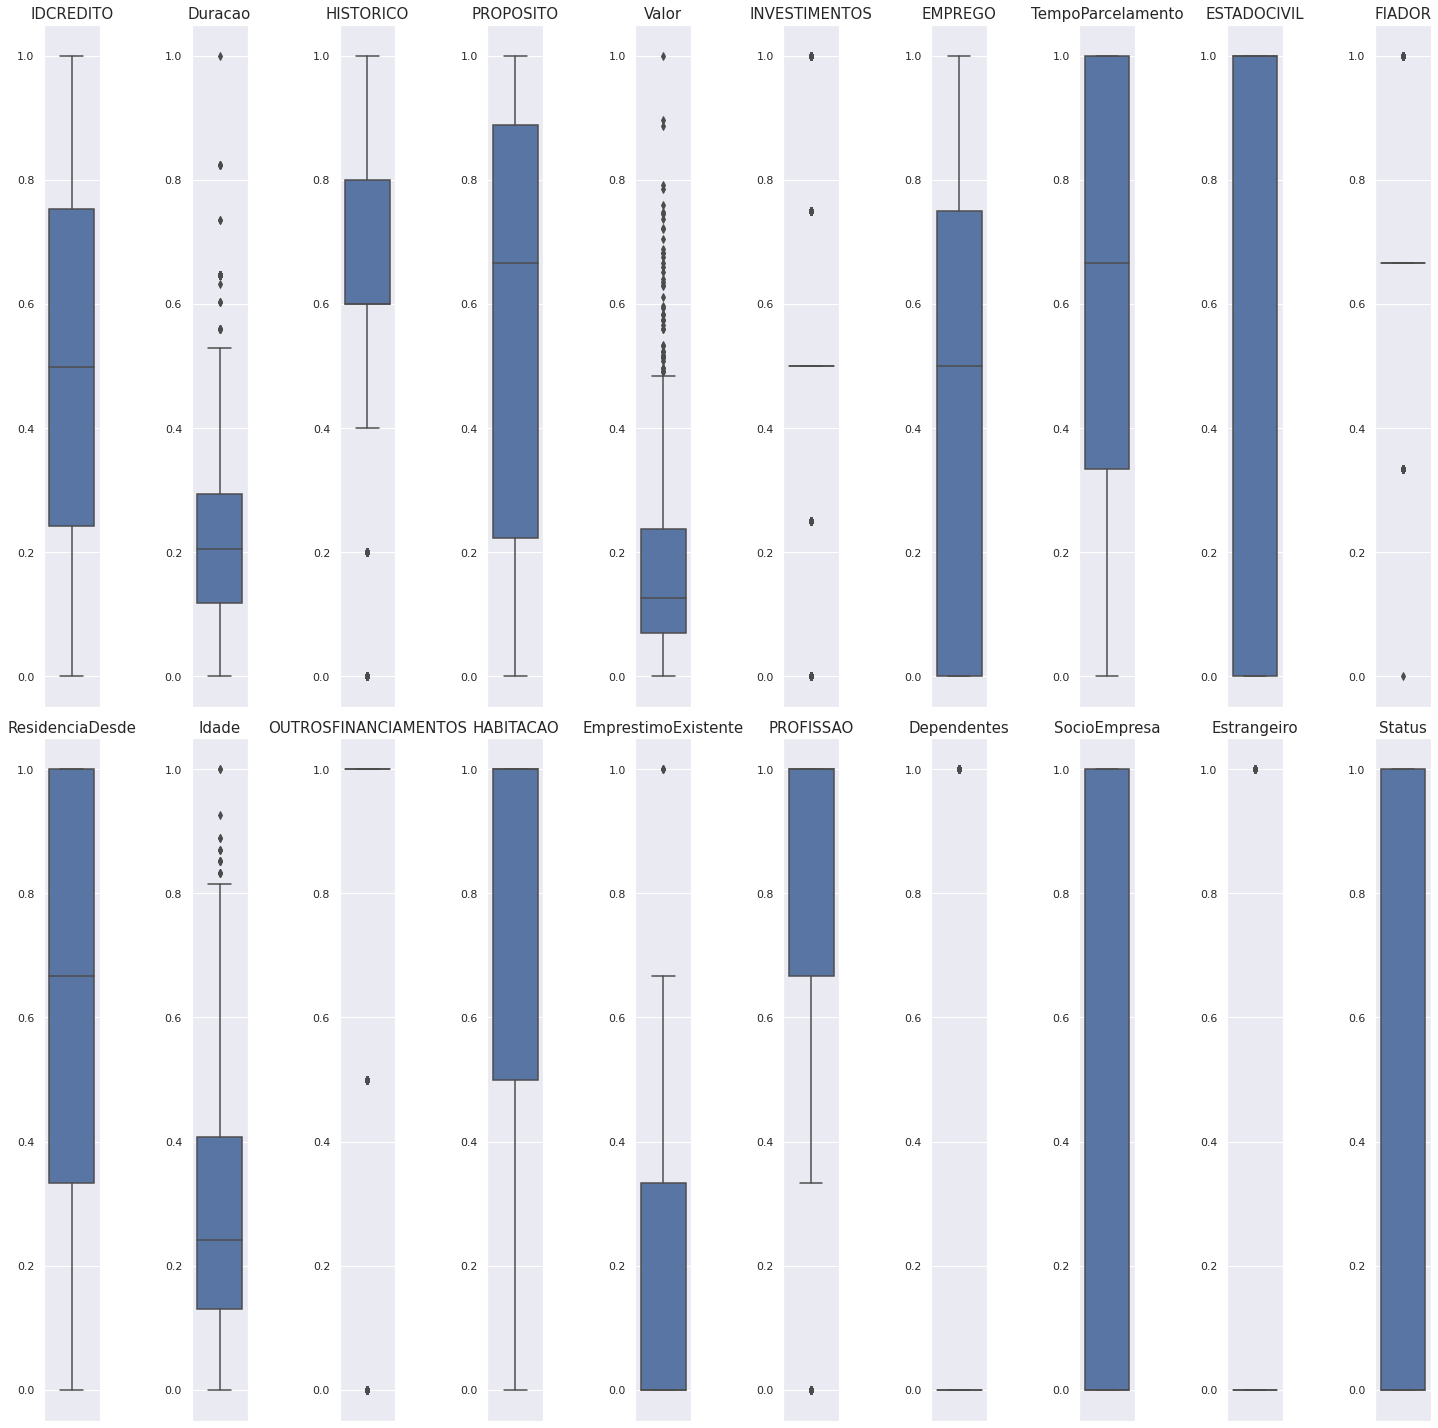

In [60]:
variables = df4_d.columns.tolist()

f, axes = plt.subplots(2, 10, figsize = (20, 20))
for var, ax in zip(variables, f.axes):
    b = sns.boxplot(y = var, data = df4_d, ax = ax)
    b.axes.set_title(var,fontsize = 15)
    b.set_ylabel("")
plt.tight_layout()
plt.show()

## 4.3 Seleção dos atributos

In [61]:
df4_3 = df4_d.drop(columns='IDCREDITO')

In [62]:
#split data
X_4 = df4_3.drop(columns = 'Status', axis = 1)
y_4 = df4_3['Status']

### 4.3.1 Random Forest como seletor de atributos

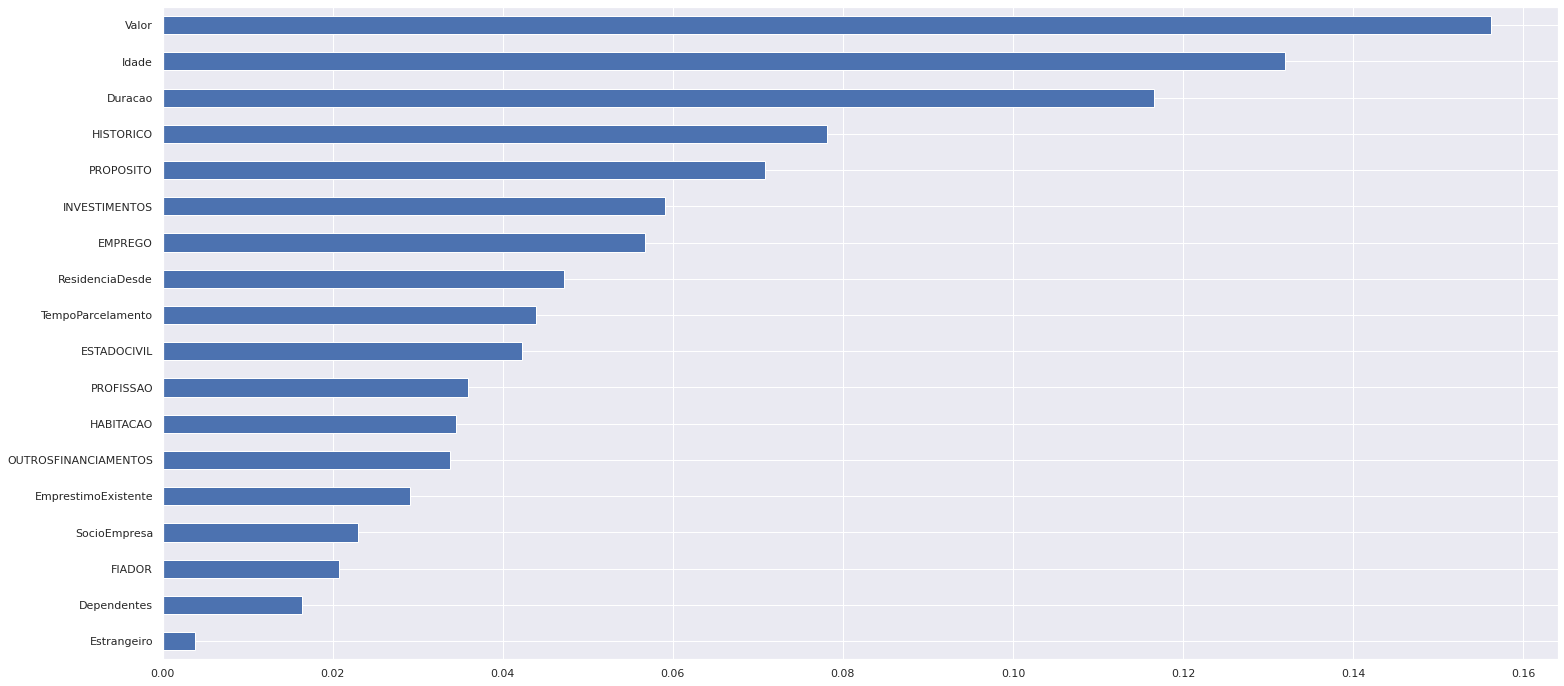

In [63]:
rf_model = RandomForestClassifier(n_jobs = -1)
rf_model.fit(X_4, y_4)

random_forest = pd.Series(rf_model.feature_importances_, index=X_4.columns)
random_forest.sort_values().plot(kind='barh')

### 4.3.2 Boruta como seletor de atributos

In [64]:
X_train_n = X_4.values
y_train_n = y_4.ravel() 

ex_model = ExtraTreesClassifier(n_jobs=-1)

boruta = BorutaPy(ex_model, n_estimators = 'auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	4
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	12
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	12
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	12
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	3
Rejected: 	12
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	12
I

6.2.1 Best features from boruta

In [65]:
cols_selected = boruta.support_.tolist()
# melhores variáveis
cols_selected_boruta = X_4.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['Duracao', 'HISTORICO', 'Valor', 'Idade']

In [66]:
# não selecionados
cols_not_selected_boruta = list(np.setdiff1d(X_4.columns, cols_selected_boruta))
cols_not_selected_boruta

['Dependentes',
 'EMPREGO',
 'ESTADOCIVIL',
 'EmprestimoExistente',
 'Estrangeiro',
 'FIADOR',
 'HABITACAO',
 'INVESTIMENTOS',
 'OUTROSFINANCIAMENTOS',
 'PROFISSAO',
 'PROPOSITO',
 'ResidenciaDesde',
 'SocioEmpresa',
 'TempoParcelamento']

### 4.3.3 Seleção manual (junção dos dois)

In [67]:
cols_selected_boruta = ['Duracao', 'HISTORICO', 'Valor', 'Idade']

cols_selected = ['Duracao', 'HISTORICO', 'Valor', 'Idade', 
                        'PROPOSITO', #a partir desse adicionei
                        'INVESTIMENTOS','EMPREGO','ResidenciaDesde', 'ESTADOCIVIL',
                        'TempoParcelamento','PROFISSAO']


feat_to_add = ['Status']

cols_selected.extend(feat_to_add)

In [68]:
df4_final = df4_3[cols_selected]

In [69]:
df4_final.head()

,Duracao,HISTORICO,Valor,Idade,PROPOSITO,INVESTIMENTOS,EMPREGO,ResidenciaDesde,ESTADOCIVIL,TempoParcelamento,PROFISSAO,Status
0,0.205882,0.2,0.127768,0.148148,0.888889,0.0,0.50,0.666667,0.000000,0.666667,1.000000,1.0
1,0.117647,0.2,0.158466,0.259259,0.222222,0.5,0.75,1.000000,1.000000,0.333333,1.000000,0.0
2,0.294118,0.6,0.173591,0.000000,0.222222,1.0,0.00,1.000000,0.666667,0.333333,1.000000,1.0
3,0.073529,0.6,0.118706,0.092593,0.222222,0.5,0.00,0.333333,1.000000,0.666667,1.000000,0.0
4,0.117647,0.8,0.062672,0.037037,0.222222,0.5,0.50,1.000000,0.000000,0.333333,0.666667,0.0


# 5.0 Modelagem pt1

Temos um problema em que, para empresa é mais aceitável não oferecer crédito a um bom pagador do que oferecer crédito a um mal pagador, logo, devemos aumentar o Recall, diminuindo os casos de falso negativo



'STATUS': Mau pagador? 1=Sim; 0=Nao;

In [70]:
df5 = df4_final.copy()

In [71]:
X = df4_final.drop(columns = 'Status', axis = 1)
y = pd.DataFrame(df4_final['Status'])

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, stratify =y, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)  

In [ ]:
!pip install yellowbrick==1.2

In [ ]:
!pip install numpy==1.21

In [ ]:
!pip install tf-estimator-nightly==2.8.0.dev2021122109

In [ ]:
!pip install pycaret

In [ ]:
!pip uninstall scikit-learn

In [ ]:
!pip install scikit-learn==0.23.2

In [73]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [74]:
###### RETIRAR COMENTÁRIO
s = setup(df5, target = 'Status')

,Description,Value
0,session_id,5449
1,Target,Status
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(700, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


create_model_container: 0
master_model_container: 0
display_container: 1
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='Status',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strat...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'passthrough'),
                

In [75]:
# Treinar modelos
compare_models(fold = 10,  round = 4,  sort = 'Recall', turbo = True)



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.6216,0.5650,0.4154,0.3994,0.4058,0.1289,0.1293,0.017
lightgbm,Light Gradient Boosting Machine,0.7014,0.6794,0.4067,0.5210,0.4510,0.2534,0.2588,0.102
qda,Quadratic Discriminant Analysis,0.7136,0.6834,0.3625,0.5613,0.4300,0.2563,0.2703,0.017
gbc,Gradient Boosting Classifier,0.7240,0.6939,0.3621,0.5989,0.4454,0.2779,0.2959,0.112
ada,Ada Boost Classifier,0.7016,0.6647,0.3612,0.5400,0.4286,0.2373,0.2488,0.109
nb,Naive Bayes,0.7239,0.6809,0.3496,0.5910,0.4304,0.2697,0.2878,0.015
rf,Random Forest Classifier,0.7219,0.7168,0.3229,0.6409,0.4083,0.2550,0.2885,0.513
et,Extra Trees Classifier,0.7035,0.7180,0.3033,0.5841,0.3812,0.2134,0.2414,0.463
svm,SVM - Linear Kernel,0.6360,0.0000,0.2779,0.5529,0.2618,0.0883,0.1336,0.016
knn,K Neighbors Classifier,0.6932,0.6075,0.2692,0.5398,0.3506,0.1777,0.2013,0.115


create_model_container: 14
master_model_container: 14
display_container: 2
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=5449, splitter='best')
compare_models() succesfully completed......................................


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=5449, splitter='best')

Melhor modelo (precisão) : Quadratic Discriminant Analysis. Desconsiderar modelo abaixo, tenho que consertar as dependências do pycaret antes de trocar o modelo	

In [78]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7551,0.7529,0.5333,0.6154,0.5714,0.4012,0.4032
1,0.6735,0.6039,0.2000,0.4286,0.2727,0.0968,0.1085
2,0.7143,0.7078,0.5333,0.5333,0.5333,0.3275,0.3275
3,0.6939,0.7216,0.4000,0.5000,0.4444,0.2368,0.2396
4,0.6531,0.6980,0.3333,0.4167,0.3704,0.1350,0.1366
5,0.6939,0.6216,0.4000,0.5000,0.4444,0.2368,0.2396
6,0.6735,0.6471,0.4000,0.4615,0.4286,0.2016,0.2026
7,0.7347,0.6913,0.5625,0.6000,0.5806,0.3869,0.3873
8,0.7143,0.6610,0.4375,0.5833,0.5000,0.3057,0.3119


create_model_container: 16
master_model_container: 16
display_container: 4
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5449, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
create_model() succesfully completed......................................


In [79]:
tuned_lgbm = tune_model(lgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6939,0.6686,0.4000,0.5000,0.4444,0.2368,0.2396
1,0.7551,0.6098,0.3333,0.7143,0.4545,0.3226,0.3616
2,0.6735,0.7216,0.2667,0.4444,0.3333,0.1347,0.1424
3,0.8163,0.7627,0.5333,0.8000,0.6400,0.5232,0.5426
4,0.6939,0.6471,0.3333,0.5000,0.4000,0.2054,0.2130
5,0.6735,0.6059,0.2000,0.4286,0.2727,0.0968,0.1085
6,0.7347,0.5667,0.2667,0.6667,0.3810,0.2497,0.2922
7,0.6735,0.6042,0.2500,0.5000,0.3333,0.1478,0.1634
8,0.7551,0.7576,0.2500,1.0000,0.4000,0.3099,0.4282


create_model_container: 17
master_model_container: 17
display_container: 5
LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.6,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=51, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=60, n_jobs=-1, num_leaves=200, objective=None,
               random_state=5449, reg_alpha=0.05, reg_lambda=0.5, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
tune_model() succesfully completed......................................


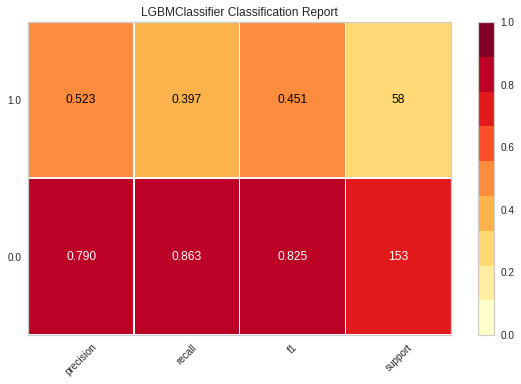

Visual Rendered Successfully
plot_model() succesfully completed......................................


In [85]:
plot_model(lgbm,plot='class_report')

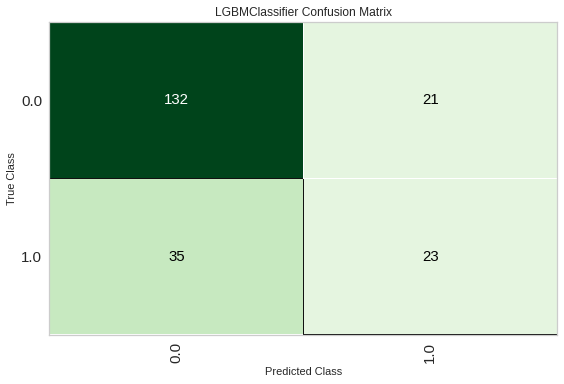

Visual Rendered Successfully
plot_model() succesfully completed......................................


In [86]:
plot_model(lgbm,plot='confusion_matrix')

In [87]:
print(lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=5449, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
save_model(lgbm,"lgbm_classifier")

# 6.0 Modelagem pt2

In [135]:
df6 = df4_final.copy()

In [136]:
X = df4_final.drop(columns = 'Status', axis = 1)
y = pd.DataFrame(df4_final['Status'])
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, stratify =y, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)  

In [137]:
# Criação da estrutura da rede neural com a classe Sequential (sequência de camadas)
modelo = Sequential()
#primeira camada oculta, 5 neuronios, 11 neuronios de entrada
modelo.add(Dense(units = 6, input_dim = 11))
#segunda camada oculta
modelo.add(Dense(units = 4))
#(é gerada uma probabilidade em cada neurônio)
modelo.add(Dense(units = 1, activation = 'sigmoid' ))

In [138]:
# Visualização da estrutura da rede neural
modelo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6)                 72        
                                                                 
 dense_13 (Dense)            (None, 4)                 28        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


In [139]:
modelo.compile(optimizer = 'adam', loss = 'binary_crossentropy',
               #metrics = ['Precision']
               metrics= [keras.metrics.Recall()])

In [ ]:
# Treinamento, dividindo a base de treinamento em uma porção para validação (validation_data)
model = modelo.fit(X_train, y_train, epochs = 250, 
           validation_data = (X_test, y_test))

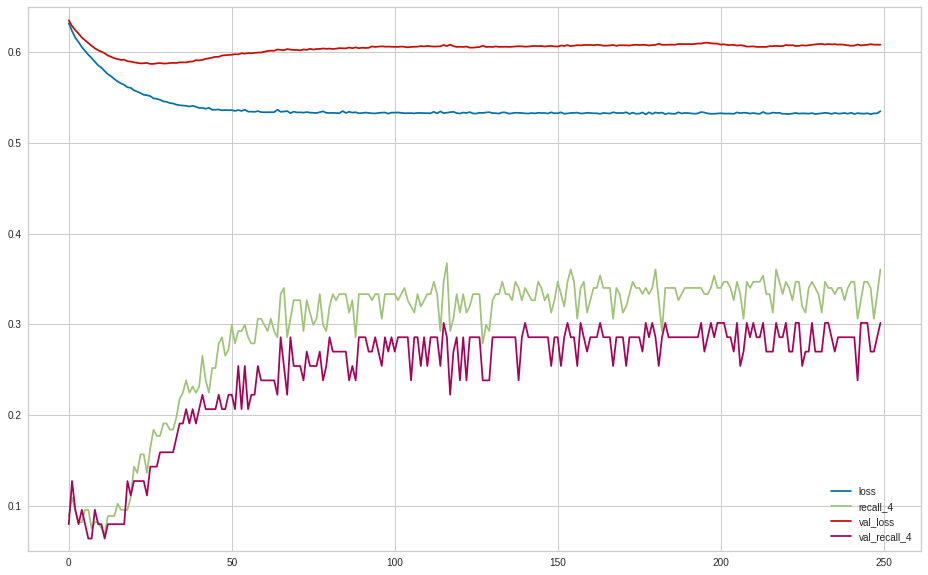

In [145]:
pd.DataFrame(model.history).plot(figsize = (16,10))
plt.grid(True)
plt.gca().set_ylim(0.05,0.65)
plt.show()

In [146]:
previsoes = modelo.predict(X_test)
#previsoes = (previsoes > 0.5)
#previsoes

In [147]:
previsoes_ = (previsoes > 0.5)

In [148]:
y_previsao_matrix = []
for i in previsoes_:
  for j in i:
    if j == True:
      y_previsao_matrix.append(1.0)
    else:
      y_previsao_matrix.append(0.0)

In [149]:
y_test_matrix = [t for t in y_test['Status']]


In [150]:
from sklearn.metrics import confusion_matrix

In [151]:
# Geração da matriz de confusão
confusao = confusion_matrix(y_test_matrix, y_previsao_matrix)
confusao

array([[129,  19],
       [ 44,  19]])

In [152]:
# Avaliação com o Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_matrix, y_previsao_matrix))

              precision    recall  f1-score   support

         0.0       0.75      0.87      0.80       148
         1.0       0.50      0.30      0.38        63

    accuracy                           0.70       211
   macro avg       0.62      0.59      0.59       211
weighted avg       0.67      0.70      0.68       211



In [153]:
modelo.save('/content/drive/MyDrive/PROJETOS_DS/formacao_cd/neural')

Assets written to: /content/drive/MyDrive/PROJETOS_DS/formacao_cd/neural/assets


# Comentários sobre a modelagem

# 7.0 Resultados do modelo em produção

In [158]:
import pickle
import pandas as pd
import numpy as np
import math

class Emprestimo( object ):
    def __init__( self ):
        self.home_path='/content/drive/MyDrive/PROJETOS_DS/formacao_cd/'
        self.PROPOSITO_scaler   = pickle.load( open( self.home_path + 'parameter/PROPOSITO_scaler.pkl', 'rb') )
        self.INVESTIMENTOS_scaler = pickle.load( open( self.home_path + 'parameter/INVESTIMENTOS_scaler.pkl', 'rb') )
        self.EMPREGO_scaler             = pickle.load( open( self.home_path + 'parameter/EMPREGO_scaler.pkl', 'rb') )
        self.ESTADOCIVIL_scaler        = pickle.load( open( self.home_path + 'parameter/ESTADOCIVIL_scaler.pkl', 'rb') )
        self.ResidenciaDesde_scaler                   = pickle.load( open( self.home_path + 'parameter/ResidenciaDesde_scaler.pkl', 'rb') )
        self.OUTROSFINANCIAMENTOS_scaler             = pickle.load( open( self.home_path + 'parameter/OUTROSFINANCIAMENTOS_scaler.pkl', 'rb') )
        self.HABITACAO_scaler             = pickle.load( open( self.home_path + 'parameter/HABITACAO_scaler.pkl', 'rb') )
        self.PROFISSAO_scaler             = pickle.load( open( self.home_path + 'parameter/PROFISSAO_scaler.pkl', 'rb') )
        self.scaler_scaler             = pickle.load( open( self.home_path + 'parameter/scaler_scaler.pkl', 'rb') )
        
    def data_cleaning( self, df1 ): 
        # FILL NA
        df1['HISTORICO'] = df1['HISTORICO'].fillna('sem_historico')
        df1['EMPREGO'] = df1['EMPREGO'].fillna('Desempregado')
        df1['ResidenciaDesde'] = df1['ResidenciaDesde'].fillna(df1['ResidenciaDesde'].median())
        df1['HABITACAO'] = df1['HABITACAO'].fillna('proria')
        df1['PROFISSAO'] = df1['PROFISSAO'].fillna('qualificado')

        # MUDANÇA DE dtype
        df1[['ResidenciaDesde']] = df1[['ResidenciaDesde']].astype(object)
        
        return df1 


    def data_preparation( self, df2 ):

        ## Transformação

        df2['PROPOSITO'] = self.PROPOSITO_scaler.transform( df2[['PROPOSITO']].values )
    
        df2['INVESTIMENTOS'] = self.INVESTIMENTOS_scaler.transform( df2[['INVESTIMENTOS']].values )

        df2['EMPREGO'] = self.EMPREGO_scaler.transform( df2[['EMPREGO']].values )
        
        df2['ESTADOCIVIL'] = self.ESTADOCIVIL_scaler.transform( df2[['ESTADOCIVIL']].values )

        df2['ResidenciaDesde'] = self.ResidenciaDesde_scaler.transform( df2[['ResidenciaDesde']].values )

        df2['OUTROSFINANCIAMENTOS'] = self.OUTROSFINANCIAMENTOS_scaler.transform( df2[['OUTROSFINANCIAMENTOS']].values )

        df2['HABITACAO'] = self.HABITACAO_scaler.transform( df2[['HABITACAO']].values )

        df2['PROFISSAO'] = self.PROFISSAO_scaler.transform( df2[['PROFISSAO']].values )

        historico_dict = {'todos pagos': 1,  'sem creditos/todos pagos': 2, 
                  'Atrasos anteriores': 3,  'existentes/pagos': 4, 
                  'Critico-outros creditos': 5, 'sem_historico': 6}
        df2['HISTORICO'] = df2['HISTORICO'].map( historico_dict )

        FIADOR_dict = {'co aplicante': 1,  'co requerente': 2, 
                          'nao': 3,  'sim': 4}
        df2['FIADOR'] = df2['FIADOR'].map( FIADOR_dict )


        ## Padronização

        aux = self.scaler_scaler.transform( df2 )

        df2_1 = pd.DataFrame(aux, columns = df2.columns)

        
        
        cols_selected = ['Duracao', 'HISTORICO', 'Valor', 'Idade', 
                        'PROPOSITO', 
                        'INVESTIMENTOS','EMPREGO','ResidenciaDesde', 'ESTADOCIVIL',
                        'TempoParcelamento','PROFISSAO']
        
        return df2_1[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )

        #y_previsao_matrix = []
        #for i in pred:
        #  for j in i:
        #    if j >0.5:
        #      y_previsao_matrix.append(1)
        #    else:
        #      y_previsao_matrix.append(0)
        
        # join pred into the original data
        original_data['prediction'] = pred
        
        return original_data

In [155]:
from pycaret.regression import load_model 

In [165]:
# carregando os dados :
df_to_predict = df_test

# loading model
#model = keras.models.load_model("/content/drive/MyDrive/PROJETOS_DS/formacao_cd/neural")
model = load_model('lgbm_classifier')

# Instantiate Rossmann class
pipeline = Emprestimo()
        
# data cleaning
df1 = pipeline.data_cleaning( df_to_predict )
        
# data preparation
df2 = pipeline.data_preparation( df1 )
        
# prediction
df_response = pipeline.get_prediction( model, df_to_predict, df2 )

Initializing load_model()
load_model(model_name=lgbm_classifier, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [166]:
df_response.head(20)

,IDCREDITO,Duracao,HISTORICO,PROPOSITO,Valor,INVESTIMENTOS,EMPREGO,TempoParcelamento,ESTADOCIVIL,FIADOR,...,Idade,OUTROSFINANCIAMENTOS,HABITACAO,EmprestimoExistente,PROFISSAO,Dependentes,SocioEmpresa,Estrangeiro,Status,prediction
521,537,6,4,8,1374,4,4,4,0,3,...,75,2,2,1,0,1,1,0,0,1
737,757,6,5,8,1299,2,0,1,3,3,...,74,2,2,3,1,2,0,1,0,0
740,760,12,5,8,691,2,3,4,3,3,...,35,2,2,2,3,1,0,0,1,0
660,679,24,4,6,2384,2,3,4,3,3,...,64,0,0,1,2,1,0,0,0,0
411,424,21,3,2,1591,0,1,4,3,3,...,34,2,2,2,0,1,0,0,0,0
678,697,12,4,6,1103,2,1,4,3,4,...,29,2,2,2,3,1,0,1,0,0
626,643,15,4,1,4623,0,0,3,3,3,...,40,2,2,1,0,1,1,0,1,0
513,529,36,4,6,2302,2,0,4,1,3,...,31,2,0,1,3,1,0,0,1,0
859,881,24,4,9,7814,2,1,3,3,3,...,38,2,2,1,0,1,1,0,0,0
136,142,36,4,6,4795,2,2,4,0,3,...,30,2,2,1,0,1,1,0,0,0


In [167]:
y_test_matrix = df_test['Status']
y_previsao_matrix = df_response['prediction']
print(classification_report(y_test_matrix, y_previsao_matrix))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       210
           1       0.52      0.48      0.50        90

    accuracy                           0.71       300
   macro avg       0.65      0.64      0.65       300
weighted avg       0.70      0.71      0.71       300



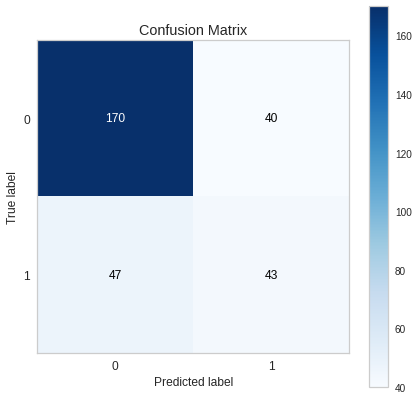

In [168]:
mt.plot_confusion_matrix(y_test_matrix, y_previsao_matrix, normalize = False,figsize=(7,7))